# Adiabatic Decompression melting of peridotite and pyroxenite mantle sources

- One of the principal uses of pMELTS (Ghiorso et al. 2002) in simulating mantle melting during adiabatic decompression.
- The Holland et al. (2018) thermodynamic database is also well calibrated for modelling melting of ultramafic and mafic components at mantle conditions.
- PetThermoTools allows the user to run melting simulations using either thermodynamic model and compare these results to recent empirical parameterisations of mantle melting (pyMelt; Matthews et al. 2022).

**Before any calculations can be run** users need to download the alphaMELTS for MATLAB files (https://magmasource.caltech.edu/gitlist/MELTS_Matlab.git/) and store them locally on their computer. These files then need to be added to the Python path by using the $sys.path.append()$ command below.

Additionally, much of the code presented here represents calculations performed using MAGEMin, not alphaMELTS for Python. As a result, please ensure that you've followed the instructions for installing MAGEMin and pyMAGEMINcalc before trying to recreate these calculations.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PetThermoTools as M
M.__version__


import sys
sys.path.append(r'MELTS')

In [3]:
# used to suppress MELTS outputs in MacOS systems (run twice)
import os
sys.stdout = open(os.devnull, 'w')
sys.stderr = open(os.devnull, 'w')

## Examining the influence of source lithology on melting behaviours

First, we'll simulate adiabatic decompression melting of a mantle peridotite at high temperatures (T$_p$ ~ 1500 $^o$C) beneath ~80 km thick lithosphere (assuming a density of 3400 kg/m$^3$), representing the type of conditions we might expect for a major hotspot such as Hawai'i.

The calculation is easy to set up. In this case we opt to use the Holland et al. (2018) thermodynamic model (though MAGEMin), and select the pre-defined bulk composition of the KLB-1 peridotite. We perform the calculation between 55000 bars (5.5 GPa) and 28000 bars (2.8 GPa).

In [4]:
Results_KLB1 = M.AdiabaticDecompressionMelting(Model = "Holland", bulk = "KLB-1",
                                          Tp_C = 1500.0, P_start_bar = 55000.0, P_end_bar = 28000.0, dp_bar = 200)

Text(0.5, 0, 'Temperature ($\\degree$C)')

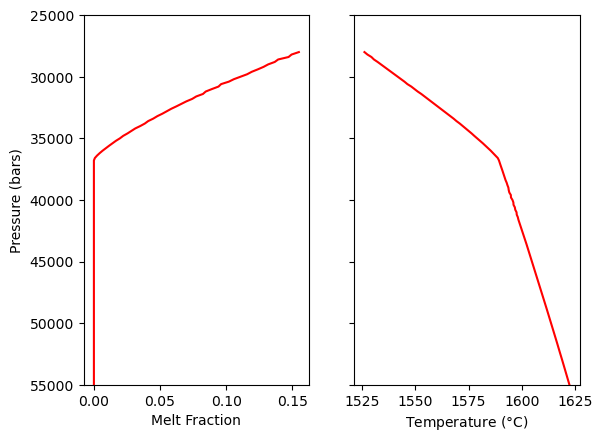

In [5]:
f, a = plt.subplots(1,2, sharey=True) 
a[0].plot(Results_KLB1['All']['mass_Liq']/Results_KLB1["Mass"].sum(axis = 1), Results_KLB1['All']['P_bar'], '-r')
a[1].plot(Results_KLB1['All']['T_C'], Results_KLB1['All']['P_bar'], '-r')

a[0].set_ylim([55000,25000])
a[0].set_ylabel('Pressure (bars)')
a[0].set_xlabel('Melt Fraction')
a[1].set_xlabel('Temperature ($\degree$C)')

However, there is ongoing debate regarding the lithology of the mantle source beneath Hawai'i, and so it might be more appropriate to model the melting behaviour of a pyroxenitic mantle lithology instead. To demonstrate that here, we load in the pre-defined composition of the KG1 silica-deficient pyroxenite and re-run the same calculation.

In [6]:
Results_KG1 = M.AdiabaticDecompressionMelting(Model = "Holland", bulk = "KG1",
                                          Tp_C = 1500.0, P_start_bar = 55000.0, P_end_bar = 28000.0, dp_bar = 200)

We can examine how these two models differ by plotting the melt fraction and temperature curves below. However, before doing so we can also use PetThermoTools to model mantle melting using the empirical parameterizations for both lherzolite and pyroxenite mantle source in pyMelt (Matthews et al. 2022). To do so, all we need to do it chance the 'Model' parameter. **Note - by default we use the MAGEMin Holland et al. (2018) model to calculate the solid adiabat and then use this to specify the starting temperature for each model. As a result, the starting temperature for both the MAGEMin and pyMelt calculations are the same even though there are slight differences in the gradient of the solid mantle adiabat between the two models.**

In [7]:
Results_KLB1_pyMelt = M.AdiabaticDecompressionMelting(Model = "pyMelt", bulk = "KLB-1",
                                          Tp_C = 1500.0, P_start_bar = 55000.0, P_end_bar = 28000.0, dp_bar = 200)
Results_KG1_pyMelt = M.AdiabaticDecompressionMelting(Model = "pyMelt", bulk = "KG1",
                                          Tp_C = 1500.0, P_start_bar = 55000.0, P_end_bar = 28000.0, dp_bar = 200)

Interestingly, pyMelt predicts mantle melting will occur at higher pressures, but with a lower melt productivity (melt produced per pressure step).

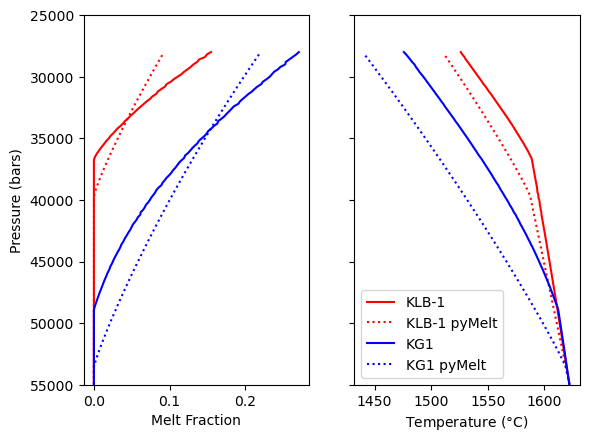

In [8]:
f, a = plt.subplots(1,2, sharey=True) 
a[0].plot(Results_KLB1['All']['mass_Liq']/Results_KLB1["Mass"].sum(axis = 1), Results_KLB1['All']['P_bar'], '-r', label = "KLB-1")
a[1].plot(Results_KLB1['All']['T_C'], Results_KLB1['All']['P_bar'], '-r', label = "KLB-1")
a[0].plot(Results_KLB1_pyMelt['All']['mass_Liq'], Results_KLB1_pyMelt['All']['P_bar'], ':r', label = "KLB-1 pyMelt")
a[1].plot(Results_KLB1_pyMelt['All']['T_C'], Results_KLB1_pyMelt['All']['P_bar'], ':r', label = "KLB-1 pyMelt")

a[0].plot(Results_KG1['All']['mass_Liq']/Results_KG1["Mass"].sum(axis = 1), Results_KG1['All']['P_bar'], '-b', label = "KG1")
a[1].plot(Results_KG1['All']['T_C'], Results_KG1['All']['P_bar'], '-b', label = "KG1")
a[0].plot(Results_KG1_pyMelt['All']['mass_Liq'], Results_KG1_pyMelt['All']['P_bar'], ':b', label = "KG1 pyMelt")
a[1].plot(Results_KG1_pyMelt['All']['T_C'], Results_KG1_pyMelt['All']['P_bar'], ':b', label = "KG1 pyMelt")

a[0].set_ylim([55000,25000])
a[0].set_ylabel('Pressure (bars)')
a[0].set_xlabel('Melt Fraction')
a[1].set_xlabel('Temperature ($\degree$C)')
a[1].legend()

## Utilizing outputs to calculate the SCSS of mantle melts

The outputs from all PetThermoTools functions are designed to integrate easily with other Python3 tools designed to facilitate petrological research (e.g., Thermobar, pyMelt, PySulfSat). A nice example of this can be found on the PySulfSat readthedocs page where fractional crystallization models at different pressures are combined with models for the sulfur content at sulfide saturation (SCSS) to determine the sulfur capacity of magmas undergoing fractional crystallization at different levels within the crust (https://pysulfsat.readthedocs.io/en/latest/Examples/Integrating_with_PyMELTS/Polybaric_FC_Model.html).

Here, we demonstrate a similar example, but instead of looking at crystallization we'll take the calculations above, which include predictions for the major element content of mantle melts produced during adiabat decompression melting beneath Hawai'i, to determine the SCSS of primary mantle melts at the pressure of melt generation. To start, we need to install (if you haven't already) and import PySulfSat.

In [9]:
# !pip install PySulfSat
import PySulfSat as ss

For this example we'll simply use the Smythe et al. (2017) SCSS model with a fixed sulfide composition. To explore how different SCSS models, or ways to determine the sulfide composition, can be modelled with PySulfSat please go to the PySulfSat readthedocs page (https://pysulfsat.readthedocs.io/en/latest/).

Without modifying the PetThermoTools outputs in any way we can use the results from the calculations above to determine the SCSS of lherozolite and pyroxenite mantle melts at the conditions of melt generation:

In [10]:
Smythe17_KLB1=ss.calculate_S2017_SCSS(df=Results_KLB1['All'], T_K=Results_KLB1['All']['T_C']+273.15, 
                                        P_kbar=Results_KLB1['All']['P_bar']/1000, 
                                        H2O_Liq=Results_KLB1['All']['H2O_Liq'], Fe_FeNiCu_Sulf=0.6, 
                                        Fe3Fet_Liq=Results_KLB1['All']['Fe3Fet_Liq'])

In [11]:
Smythe17_KG1=ss.calculate_S2017_SCSS(df=Results_KG1['All'], T_K=Results_KG1['All']['T_C']+273.15, 
                                        P_kbar=Results_KG1['All']['P_bar']/1000, 
                                        H2O_Liq=Results_KG1['All']['H2O_Liq'], Fe_FeNiCu_Sulf=0.6, 
                                        Fe3Fet_Liq=Results_KG1['All']['Fe3Fet_Liq'])

To examine these results we can plot the SCSS against pressure. It is also informative to plot different chemical parameters against pressure (or directly against SCSS) to understand what components are influencing the SCSS calculations:

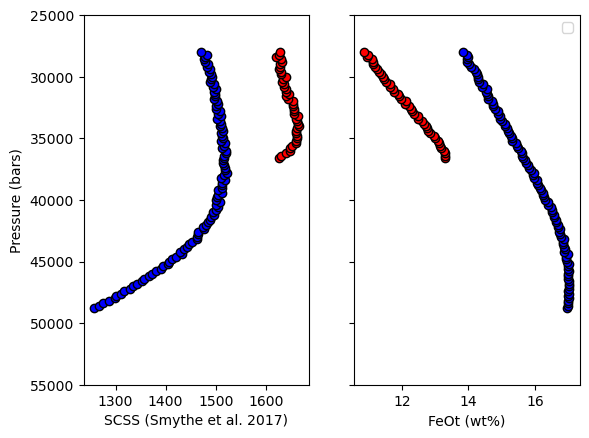

In [12]:
f, a = plt.subplots(1,2, sharey = True)
a[0].plot(Smythe17_KLB1['SCSS2_ppm_ideal_Smythe2017'],
       Results_KLB1['All']['P_bar'], 'ok', mfc = 'r')
a[0].plot(Smythe17_KG1['SCSS2_ppm_ideal_Smythe2017'],
       Results_KG1['All']['P_bar'], 'ok', mfc = 'b')

a[1].plot(Results_KLB1['All']['FeOt_Liq'],
       Results_KLB1['All']['P_bar'], 'ok', mfc = 'r')
a[1].plot(Results_KG1['All']['FeOt_Liq'],
       Results_KG1['All']['P_bar'], 'ok', mfc = 'b')

a[0].set_ylim([55000,25000])
a[0].set_ylabel('Pressure (bars)')
a[0].set_xlabel('SCSS (Smythe et al. 2017)')
a[1].set_xlabel('FeOt (wt%)')
a[1].legend()

In [ ]:
import PetThermoTools as ptt

In [ ]:
Model_choice = ["pMELTS", "Holland", "pyMelt"]
Results = {}
for m in Model_choice:
    Results[m] = ptt.AdiabaticDecompressionMelting(Model = m, bulk = "KLB-1",
        Tp_C = 1320.0, P_start_bar = 30000.0, P_end_bar = 2000.0, dp_bar = 333.3)